In [1]:
## Implemention Model Based Anamoly Detection of IoT Network Data using Mutli class Adaptive Boosting with SMOTE.

In [1]:
# Install the dependencies:
! pip install kaggle

In [2]:
!nvidia-smi

Tue Feb  9 10:33:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
! pip install google

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manikanta3377","key":"2ed4ef996a41929ca24b9311e9b6f5c2"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change permissions of kaggle.json to 600
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d francoisxa/ds2ostraffictraces

100% 4.30M/4.30M [00:00<00:00, 44.1MB/s]



In [7]:
from zipfile import ZipFile
file = '/content/ds2ostraffictraces.zip'
with ZipFile(file,'r') as zip:
  zip.extractall()
  print('done')

done


In [8]:
import pandas as pd
df = pd.read_csv('/content/mainSimulationAccessTraces.csv')
df.head()

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
0,lightcontrol2,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,registerService,none,1520031600000,normal
1,lightcontrol3,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,registerService,none,1520031603269,normal
2,lightcontrol1,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,registerService,none,1520031603279,normal
3,lightcontrol4,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,registerService,none,1520031603290,normal
4,movement4,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,registerService,none,1520031603464,normal


In [9]:
#Let's have a look at the information of the given data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357952 entries, 0 to 357951
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sourceID                   357952 non-null  object
 1   sourceAddress              357952 non-null  object
 2   sourceType                 357952 non-null  object
 3   sourceLocation             357952 non-null  object
 4   destinationServiceAddress  357952 non-null  object
 5   destinationServiceType     357952 non-null  object
 6   destinationLocation        357952 non-null  object
 7   accessedNodeAddress        357952 non-null  object
 8   accessedNodeType           357804 non-null  object
 9   operation                  357952 non-null  object
 10  value                      355902 non-null  object
 11  timestamp                  357952 non-null  int64 
 12  normality                  357952 non-null  object
dtypes: int64(1), object(12)
memory usage: 35.5+ 

In [10]:
df.describe()

,timestamp
count,3.579520e+05
mean,1.520078e+12
std,2.465664e+07
min,1.520032e+12
25%,1.520057e+12
50%,1.520080e+12
75%,1.520099e+12
max,1.520118e+12


In [11]:
df.columns

Index(['sourceID', 'sourceAddress', 'sourceType', 'sourceLocation',
       'destinationServiceAddress', 'destinationServiceType',
       'destinationLocation', 'accessedNodeAddress', 'accessedNodeType',
       'operation', 'value', 'timestamp', 'normality'],
      dtype='object')

In [12]:
# Let's start preprocessing our data:
df.isna().sum()

sourceID                        0
sourceAddress                   0
sourceType                      0
sourceLocation                  0
destinationServiceAddress       0
destinationServiceType          0
destinationLocation             0
accessedNodeAddress             0
accessedNodeType              148
operation                       0
value                        2050
timestamp                       0
normality                       0
dtype: int64

In [13]:
# So cearly there 148 records from accessedNodeType and 2050 records from value are null so let's drop them:
df = df.dropna()

In [14]:
df.head()

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
0,lightcontrol2,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,registerService,none,1520031600000,normal
1,lightcontrol3,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,registerService,none,1520031603269,normal
2,lightcontrol1,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,registerService,none,1520031603279,normal
3,lightcontrol4,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,registerService,none,1520031603290,normal
4,movement4,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,registerService,none,1520031603464,normal


In [15]:
df['value']

0            none
1            none
2            none
3            none
4            none
           ...   
357947    20.3479
357948          9
357949       true
357950          0
357951    20.4131
Name: value, Length: 355902, dtype: object

In [16]:
df.isna().sum()

sourceID                     0
sourceAddress                0
sourceType                   0
sourceLocation               0
destinationServiceAddress    0
destinationServiceType       0
destinationLocation          0
accessedNodeAddress          0
accessedNodeType             0
operation                    0
value                        0
timestamp                    0
normality                    0
dtype: int64

In [17]:
# So We got rid off the null values lets convert categorical fields to one hot encoders for training the modeL:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [18]:
# So let's create a helper function to encode all the columns:
# So let's get all the columns that need to be encoded:
# So if we look at the all columns of our data we need to encode all the columns except value and timestamp column:
# So let's do one hot encoding for these columns:
# So let's first get these columns:
one_hot_columns = ['sourceID', 'sourceAddress', 'sourceType', 'sourceLocation',
       'destinationServiceAddress', 'destinationServiceType',
       'destinationLocation', 'accessedNodeAddress', 'accessedNodeType',
       'operation','normality']
# So these are the columns to be encoded:

In [19]:
# The helper function:
def encode(colname):
  df[colname] = le.fit_transform(df[colname])

In [20]:
# so we defined our helper so let's pass our columns one by one:
for colname in one_hot_columns:
  encode(colname)

In [21]:
# So it's doen let's see our data once :
df.head()

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
0,21,30,2,3,29,2,3,57,5,1,none,1520031600000,7
1,32,70,2,4,67,2,4,132,5,1,none,1520031603269,7
2,15,1,2,2,0,2,2,0,5,1,none,1520031603279,7
3,33,77,2,7,72,2,7,142,5,1,none,1520031603290,7
4,55,78,3,7,73,3,7,144,6,1,none,1520031603464,7


In [ ]:
# Now we need to normalize the values before feeding the data into calssification Algorithm:
# So let's normalize the values:
# Use Standard Scaler to normal the values using Normal Distribution:
# But to normalize the values all the cells should contain number or Strings that can be converted to number:
# But we have some of the records of the value column as none
# It's better to check all the values of the value column once:
for i in df['value']:
  print(i)

Streaming output truncated to the last 5000 lines.
1
1
19.9812
19.5598
1
0
1
20.3200
1
false
20.1392
20.2218
6
20.3731
20.1787
5
20.4605
1
5
19.9166
19.8421
5
19.6611
20.0081
20.2210
0
19.6611
19.8367
19.5728
20.0131
20.0791
20.1489
1
19.9216
20.1489
20.4646
0
5
19.5728
true
6
6
6
false
5
false
5
false
0
20.1667
20.1687
1
20.2422
1
19.6848
20.2210
4
true
5
5
20.4139
19.8741
20.0660
19.6994
false
5
4
false
4
6
5
4
5
5
0
19.7633
19.5681
0
1
20.0081
0
20.1667
1
10
19.9771
false
20.4987
1
19.8741
19.9183
0
19.9216
0
19.7633
1
19.5681
0
1
19.6994
20.4139
1
1
20.0131
1
1
19.8367
20.4646
1
20.0791
20.4987
false
5
4
4
4
true
true
20.4750
19.9743
20.2581
0
20.4750
20.2715
20.0161
20.0070
19.5237
19.8710
20.2545
19.7271
1
0
6
20.0161
5
true
4
7
false
false
19.5237
7
4
false
20.1925
0
20.0660
1
19.6848
19.5959
1
19.9743
5
true
6
6
19.8313
20.0461
19.5710
20.4913
false
false
4
3
5
4
3
3
4
4
0
19.6648
20.0967
0
1
20.2581
0
20.1925
1
10
19.9183
false
20.4803
1
19.8313
20.2328
0
0
19.6648
1
20.2545
2

In [22]:
# So It' clear that some of the values of the value column are Strings: 'none' 'false' and 'true'
# So let's first convert them
# none => 0 , false => 0 and true => 1
df['value'] = df['value'].replace('none',0)
df['value'] = df['value'].replace('false',0)
df['value'] = df['value'].replace('true',1)

In [23]:
# So it's clear that some of values are still strings let's first convert them to numbers:
for i in df['value']:
  if(type(i)==str):
    df['value'] = df['value'].replace(i,float(i))

ValueError: ignored

In [24]:
# some of them are 'twenty' are converted to int 20:
for i in df['value']:
  if type(i)==str:
    if i == 'twenty':
      df['value']= df['value'].replace(i,20)

In [25]:
# Now let's convert all the other strigs to it's corresponding float and int equivalents:
for i in df['value']:
  if(type(i)==str):
    df['value'] = df['value'].replace(i,float(i))

ValueError: ignored

In [26]:
# Oh!! We see that some of the values are strings that are org.ds2os____ like strings let's find the count and indices of them:
# So that we can apply some strategy on these values:
# So find indices of org.ds2os__like strings:
# Let's create and list to store those indices:
ls =[]
count=0
for i in df['value']:
  if(type(i)==str):
    if(i.startswith('org')):
      print(count)
      ls.append(count)
      count+=1
      continue
  count+=1

358
359
362
373
384
401
404
412
454
459
467


In [27]:
# so the indices are in the ls list:
ls

[358, 359, 362, 373, 384, 401, 404, 412, 454, 459, 467]

In [28]:
# let's check once there are same:
for idx in ls:
  print(df.iloc[idx]['value'])

org.ds2os.vsl.core.utils.AddressParameters@463d9146
org.ds2os.vsl.core.utils.AddressParameters@699d52f5
org.ds2os.vsl.core.utils.AddressParameters@273343f8
org.ds2os.vsl.core.utils.AddressParameters@181ae4a8
org.ds2os.vsl.core.utils.AddressParameters@5c494e7d
org.ds2os.vsl.core.utils.AddressParameters@6876d7bb
org.ds2os.vsl.core.utils.AddressParameters@4ff97c45
org.ds2os.vsl.core.utils.AddressParameters@3ebb34ed
org.ds2os.vsl.core.utils.AddressParameters@2c82b391
org.ds2os.vsl.core.utils.AddressParameters@61ba9b2b
org.ds2os.vsl.core.utils.AddressParameters@715cced


In [29]:
# okay we are good to go:
# It's clear there are 11 records that org.___ like strings let's drop these rows:
for idx in ls:
  df.drop(index=idx,inplace=True,axis=0)

In [ ]:
for i in df['value']:
  print(i)

Streaming output truncated to the last 5000 lines.
1.0
1.0
19.9812
19.5598
1.0
0.0
1.0
20.3200
1.0
0
20.1392
20.2218
6
20.3731
20.1787
5
20.4605
1.0
5
19.9166
19.8421
5
19.6611
20.0081
20.2210
0.0
19.6611
19.8367
19.5728
20.0131
20.0791
20.1489
1.0
19.9216
20.1489
20.4646
0.0
5
19.5728
1
6
6
6
0
5
0
5
0
0.0
20.1667
20.1687
1.0
20.2422
1.0
19.6848
20.2210
4
1
5
5
20.4139
19.8741
20.0660
19.6994
0
5
4
0
4
6
5
4
5
5
0.0
19.7633
19.5681
0.0
1.0
20.0081
0.0
20.1667
1.0
10.0
19.9771
0
20.4987
1.0
19.8741
19.9183
0.0
19.9216
0.0
19.7633
1.0
19.5681
0.0
1.0
19.6994
20.4139
1.0
1.0
20.0131
1.0
1.0
19.8367
20.4646
1.0
20.0791
20.4987
0
5
4
4
4
1
1
20.475
19.9743
20.2581
0.0
20.475
20.2715
20.0161
20.0070
19.5237
19.8710
20.2545
19.7271
1.0
0.0
6
20.0161
5
1
4
7
0
0
19.5237
7
4
0
20.1925
0.0
20.0660
1.0
19.6848
19.5959
1.0
19.9743
5
1
6
6
19.8313
20.0461
19.5710
20.4913
0
0
4
3
5
4
3
3
4
4
0.0
19.6648
20.0967
0.0
1.0
20.2581
0.0
20.1925
1.0
10.0
19.9183
0
20.4803
1.0
19.8313
20.2328
0.0
0.0
19.66

In [30]:
df['normality'].value_counts()

7    347918
0      4000
4      1531
2       889
3       657
5       532
1       242
6       122
Name: normality, dtype: int64

In [31]:
# So let's normalize the data using StandardScaler:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [32]:
df.columns

Index(['sourceID', 'sourceAddress', 'sourceType', 'sourceLocation',
       'destinationServiceAddress', 'destinationServiceType',
       'destinationLocation', 'accessedNodeAddress', 'accessedNodeType',
       'operation', 'value', 'timestamp', 'normality'],
      dtype='object')

In [33]:
features = ['sourceID', 'sourceAddress', 'sourceType', 'sourceLocation',
       'destinationServiceAddress', 'destinationServiceType',
       'destinationLocation', 'accessedNodeAddress', 'accessedNodeType',
       'operation', 'value', 'timestamp']
autoscaler = StandardScaler()
df[features] = autoscaler.fit_transform(df[features])

In [34]:
#checking the head to see all the values are normalized:
df.head(10)

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
0,-0.575476,-0.544898,-0.337070,-1.017078,-0.488958,-0.153969,-1.079185,-0.519181,0.524381,0.05512,-0.040228,-1.861331,7
1,-0.208402,0.894535,-0.337070,-0.835697,0.940672,-0.153969,-0.889480,0.904585,0.524381,0.05512,-0.040228,-1.861199,7
2,-0.775698,-1.588487,-0.337070,-1.198459,-1.579993,-0.153969,-1.268891,-1.601243,0.524381,0.05512,-0.040228,-1.861199,7
3,-0.175032,1.146436,-0.337070,-0.291554,1.128782,-0.153969,-0.320362,1.094421,0.524381,0.05512,-0.040228,-1.861198,7
4,0.559115,1.182422,0.116207,-0.291554,1.166404,0.412188,-0.320362,1.132388,0.869710,0.05512,-0.040228,-1.861191,7
5,0.926189,-0.400955,0.569484,-1.017078,-0.413715,0.978345,-1.079185,-0.424263,1.215040,0.05512,-0.040228,-1.861191,7
6,0.158671,-0.472927,0.116207,-1.017078,-0.451337,0.412188,-1.079185,-0.481214,0.869710,0.05512,-0.040228,-1.861191,7
7,1.326633,1.218407,0.569484,-0.291554,1.204025,0.978345,-0.320362,1.189338,1.215040,0.05512,-0.040228,-1.861191,7
8,0.759337,-1.480530,0.569484,-1.198459,-1.504749,0.978345,-1.268891,-1.506326,1.215040,0.05512,-0.040228,-1.861190,7
9,-0.041551,-1.552502,0.116207,-1.198459,-1.542371,0.412188,-1.268891,-1.563276,0.869710,0.05512,-0.040228,-1.861161,7


In [35]:
# So Perfect Let's split it into train and test:
# Before that let's declare X for our independent features and y for dependent feature:
X =df.drop(['normality'],axis=1)
y =df['normality']

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
n_classes = 8

### Now Let's apply different ML algorithms to classify:

In [51]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=1)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [52]:
pred = rfc.predict(X_test)

In [53]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve,f1_score,auc

In [54]:
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print('\n')
print(classification_report(y_test,pred))

0.9900531994605125


[[  1176      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0     71]
 [     0      0      0      0      0      0      0    256]
 [     0      0      0     76      0      0      0    107]
 [     0      0      0      0     18      0      0    462]
 [     0      0      0      0      0      0      0    158]
 [     0      0      0      0      0      0     39      0]
 [     7      0      0      0      1      0      0 104397]]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1176
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00       256
           3       1.00      0.42      0.59       183
           4       0.95      0.04      0.07       480
           5       0.00      0.00      0.00       158
           6       1.00      1.00      1.00        39
           7       0.99      1.00      0.99    104405

    accuracy    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix Visualisation for Random Forests:

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(69.0, 0.5, 'Truth')

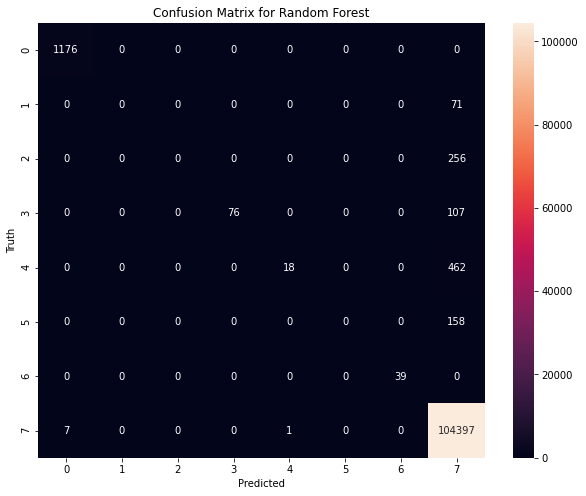

In [56]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [57]:
import numpy as np

In [58]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Precision : nan
Specificity is: 0.9442351416539472
Sensitivity is : 0.4315904902206702
F1 Score is : 0.4563736129259413
roc_auc_score is: 0.9993191675699353
True Positive : [  1176      0      0     76     18      0     39 104397]
True Positive sum Is : 105706
False Positive : [   7    0    0    0    1    0    0 1054]
False Positive sum Is : 1062
True Negative : [105585 106697 106512 106585 106287 106610 106729   1309]
True Negative sum Is : 746314
False Negative : [  0  71 256 107 462 158   0   8]
False Negative sum Is : 1062


### Logistic Regression:

In [59]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
pred = lr.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print('\n')
print(classification_report(y_test,pred))

0.9932002098006893


[[  1176      0      0      0      0      0      0      0]
 [     0     54      0      0      0      0      0     17]
 [     0      0    250      0      0      0      0      6]
 [     0      0      0    147      0      0      0     36]
 [     0      0      5      0    215      0      0    260]
 [     0      0      0      0     11      0      0    147]
 [     0      0      0      0      0      0     39      0]
 [   196      0      0     39      3      5      1 104161]]


              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1176
           1       1.00      0.76      0.86        71
           2       0.98      0.98      0.98       256
           3       0.79      0.80      0.80       183
           4       0.94      0.45      0.61       480
           5       0.00      0.00      0.00       158
           6       0.97      1.00      0.99        39
           7       1.00      1.00      1.00    104405

    accuracy    

Text(69.0, 0.5, 'Truth')

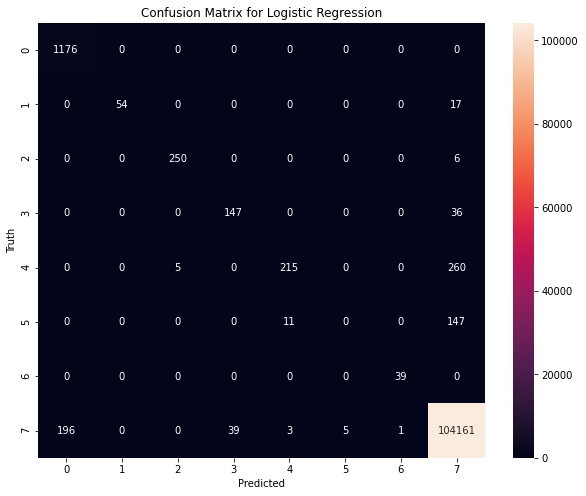

In [61]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.8171585382778538
Specificity is: 0.9750420028989043
Sensitivity is : 0.7482480228312257
F1 Score is : 0.7690914557592107
roc_auc_score is: 0.9993191675699353
True Positive : [  1176     54    250    147    215      0     39 104161]
True Positive sum Is : 106042
False Positive : [196   0   5  39  14   5   1 466]
False Positive sum Is : 726
True Negative : [105396 106697 106507 106546 106274 106605 106728   1897]
True Negative sum Is : 746650
False Negative : [  0  17   6  36 265 158   0 244]
False Negative sum Is : 726


### Decision Tree

In [63]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth = 5, random_state = 1)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [64]:
pred = dtc.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print('\n')
print(classification_report(y_test,pred))

0.9918514910834707


[[  1176      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0     71]
 [     0      0      0      0      3      0      0    253]
 [     0      0      0     76      0      0      0    107]
 [     0      0      0      0    387      0      0     93]
 [     0      0      0      0      0      0      0    158]
 [     0      0      0      0      0      0     39      0]
 [     4      0      0      0    181      0      0 104220]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1176
           1       0.00      0.00      0.00        71
           2       0.00      0.00      0.00       256
           3       1.00      0.42      0.59       183
           4       0.68      0.81      0.74       480
           5       0.00      0.00      0.00       158
           6       1.00      1.00      1.00        39
           7       0.99      1.00      1.00    104405

    accuracy    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(69.0, 0.5, 'Truth')

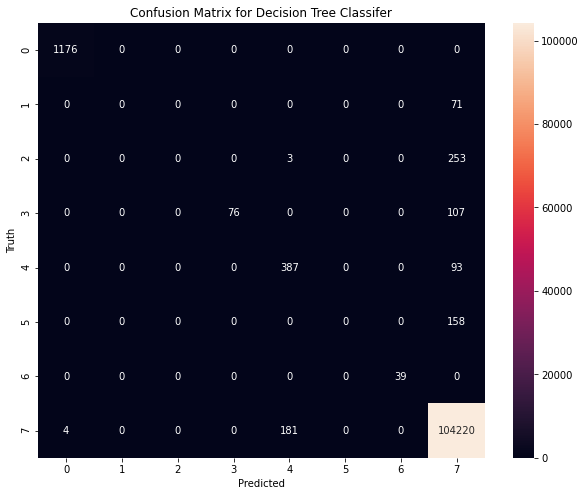

In [65]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Decision Tree Classifer')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [66]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Precision : nan
Specificity is: 0.9637018508605899
Sensitivity is : 0.5274723250825063
F1 Score is : 0.5396842546850869
roc_auc_score is: 0.9993191675699353
True Positive : [  1176      0      0     76    387      0     39 104220]
True Positive sum Is : 105898
False Positive : [  4   0   0   0 184   0   0 682]
False Positive sum Is : 870
True Negative : [105588 106697 106512 106585 106104 106610 106729   1681]
True Negative sum Is : 746506
False Negative : [  0  71 256 107  93 158   0 185]
False Negative sum Is : 870


### Linear Discriminant Analysis:

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [68]:
pred = lda.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print('\n')
print(classification_report(y_test,pred))

0.9822418702232879




              precision    recall  f1-score   support

           0       0.74      0.51      0.61      1176
           1       1.00      0.76      0.86        71
           2       0.90      0.33      0.48       256
           3       0.17      0.39      0.24       183
           4       0.98      0.24      0.39       480
           5       0.00      0.00      0.00       158
           6       0.22      1.00      0.36        39
           7       0.99      1.00      0.99    104405

    accuracy                           0.98    106768
   macro avg       0.63      0.53      0.49    106768
weighted avg       0.98      0.98      0.98    106768



Text(69.0, 0.5, 'Truth')

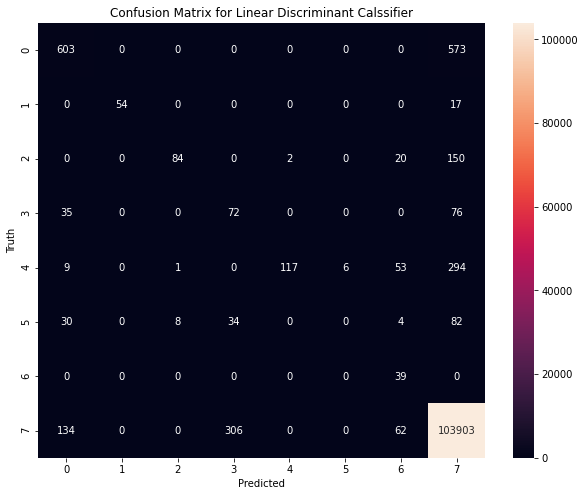

In [69]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Linear Discriminant Calssifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [70]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.6265577350446463
Specificity is: 0.9361168436661031
Sensitivity is : 0.5292284883040344
F1 Score is : 0.49204368490212136
roc_auc_score is: 0.9993191675699353
True Positive : [   603     54     84     72    117      0     39 103903]
True Positive sum Is : 104872
False Positive : [ 208    0    9  340    2    6  139 1192]
False Positive sum Is : 1896
True Negative : [105384 106697 106503 106245 106286 106604 106590   1171]
True Negative sum Is : 745480
False Negative : [573  17 172 111 363 158   0 502]
False Negative sum Is : 1896


### MLP Classifier:

In [71]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [72]:
pred = mlp.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print(classification_report(y_test,pred))

0.999597257605275


[[  1176      0      0      0      0      0      0      0]
 [     0     71      0      0      0      0      0      0]
 [     0      0    256      0      0      0      0      0]
 [     0      0      0    183      0      0      0      0]
 [     0      0      0      0    480      0      0      0]
 [     0      0      0      0      0    158      0      0]
 [     0      0      0      0      0      0     39      0]
 [    42      0      0      0      1      0      0 104362]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1176
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00       256
           3       1.00      1.00      1.00       183
           4       1.00      1.00      1.00       480
           5       1.00      1.00      1.00       158
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00    104405

    accuracy       

Text(69.0, 0.5, 'Truth')

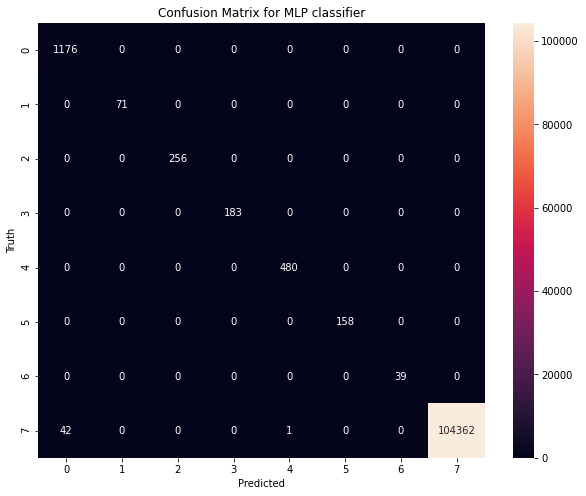

In [73]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for MLP classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [74]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.9954297799125386
Specificity is: 0.9999491042742896
Sensitivity is : 0.9999485177912935
F1 Score is : 0.9976511982967882
roc_auc_score is: 0.9993191675699353
True Positive : [  1176     71    256    183    480    158     39 104362]
True Positive sum Is : 106725
False Positive : [42  0  0  0  1  0  0  0]
False Positive sum Is : 43
True Negative : [105550 106697 106512 106585 106287 106610 106729   2363]
True Negative sum Is : 747333
False Negative : [ 0  0  0  0  0  0  0 43]
False Negative sum Is : 43


### Adaboost:

In [75]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5,random_state = 1),n_estimators = 50)
adb.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [76]:
pred = adb.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print(classification_report(y_test,pred))

0.9999812677955942


[[  1176      0      0      0      0      0      0      0]
 [     0     71      0      0      0      0      0      0]
 [     0      0    256      0      0      0      0      0]
 [     0      0      0    183      0      0      0      0]
 [     0      0      0      0    480      0      0      0]
 [     0      0      0      0      0    158      0      0]
 [     0      0      0      0      0      0     39      0]
 [     1      0      0      0      1      0      0 104403]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1176
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00       256
           3       1.00      1.00      1.00       183
           4       1.00      1.00      1.00       480
           5       1.00      1.00      1.00       158
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00    104405

    accuracy      

Text(69.0, 0.5, 'Truth')

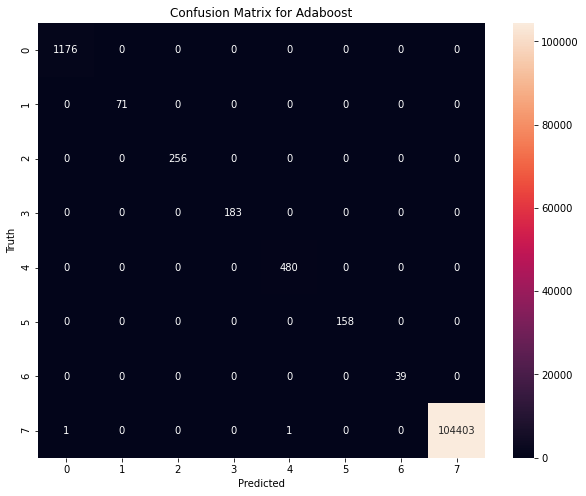

In [77]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Adaboost')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [78]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.9996339225311188
Specificity is: 0.9999976401482195
Sensitivity is : 0.9999976054786648
F1 Score is : 0.9998156062151657
roc_auc_score is: 0.9993191675699353
True Positive : [  1176     71    256    183    480    158     39 104403]
True Positive sum Is : 106766
False Positive : [1 0 0 0 1 0 0 0]
False Positive sum Is : 2
True Negative : [105591 106697 106512 106585 106287 106610 106729   2363]
True Negative sum Is : 747374
False Negative : [0 0 0 0 0 0 0 2]
False Negative sum Is : 2


## Now we will see if the results will further be improved Let's go:

### Let's handle class imbalance by apply oversampling techniques:

In [79]:
# Now Let's handle imbalnce nature of the data:
# Note we have to apply SMOTE over sampling on the train data only since it randomly generates samples which we use only for training:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter (y_train)
print(counter)

Counter({7: 243513, 0: 2824, 4: 1051, 2: 633, 3: 474, 5: 374, 1: 171, 6: 83})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


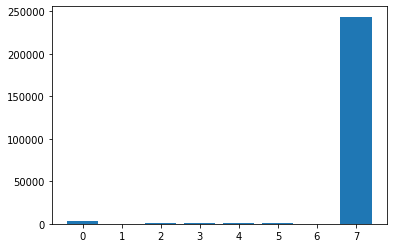

In [80]:
# plot the distribution before ovesampling:
counter = Counter(y_train)
plt.bar(counter.keys(), counter.values())
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Class=7, n=243513 (12.500%)
Class=4, n=243513 (12.500%)
Class=0, n=243513 (12.500%)
Class=3, n=243513 (12.500%)
Class=1, n=243513 (12.500%)
Class=5, n=243513 (12.500%)
Class=2, n=243513 (12.500%)
Class=6, n=243513 (12.500%)


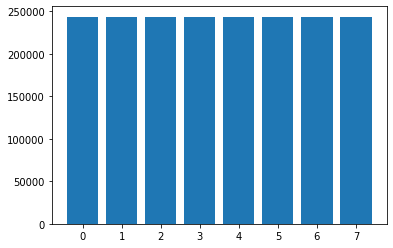

In [81]:
# Now Let's handle imbalnce nature of the data:
# Note we have to apply SMOTE over sampling on the train data only since it randomly generates samples which we use only for training:
from imblearn.over_sampling import SMOTE
from collections import Counter

oversample=SMOTE()
X_train,y_train=oversample.fit_resample(X_train,y_train)
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [82]:
print('After resampling Original dataset {}'.format(Counter(y_train)))


After resampling Original dataset Counter({7: 243513, 4: 243513, 0: 243513, 3: 243513, 1: 243513, 5: 243513, 2: 243513, 6: 243513})


### We are done with OverSampling, Now let's apply ML Algorithms:

### Random Forest After oversampling:

In [84]:
from sklearn.ensemble import RandomForestClassifier 
rfcos = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=1)
rfcos.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [85]:
pred = rfcos.predict(X_test)

In [86]:
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print('\n')
print(classification_report(y_test,pred))

0.8612130975573206


[[ 1176     0     0     0     0     0     0     0]
 [    0    71     0     0     0     0     0     0]
 [    0     0   253     0     0     0     0     3]
 [    0     0     0   183     0     0     0     0]
 [    0     0     0     0   470     0     0    10]
 [    0     0     0     0     0   158     0     0]
 [    0     0     0     0     0     0    39     0]
 [  138     0     0   714     1 13952     0 89600]]


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1176
           1       1.00      1.00      1.00        71
           2       1.00      0.99      0.99       256
           3       0.20      1.00      0.34       183
           4       1.00      0.98      0.99       480
           5       0.01      1.00      0.02       158
           6       1.00      1.00      1.00        39
           7       1.00      0.86      0.92    104405

    accuracy                           0.86    106768
   macro avg       0.76   

Text(69.0, 0.5, 'Truth')

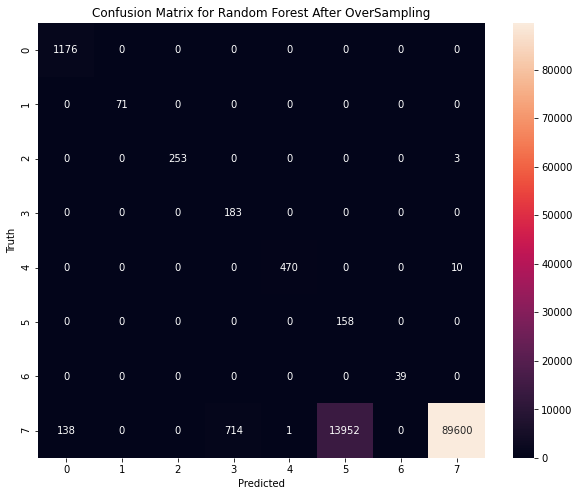

In [87]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Random Forest After OverSampling')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [88]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.7634900085615857
Specificity is: 0.9819517237471898
Sensitivity is : 0.9782055453996257
F1 Score is : 0.7764724533164453
roc_auc_score is: 0.9993191675699353
True Positive : [ 1176    71   253   183   470   158    39 89600]
True Positive sum Is : 91950
False Positive : [  138     0     0   714     1 13952     0    13]
False Positive sum Is : 14818
True Negative : [105454 106697 106512 105871 106287  92658 106729   2350]
True Negative sum Is : 732558
False Negative : [    0     0     3     0    10     0     0 14805]
False Negative sum Is : 14818


### Logistic Regression After oversampling:

In [89]:
from sklearn.linear_model import LogisticRegression
lros = LogisticRegression(random_state=1)
lros.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
pred = lros.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print('\n')
print(classification_report(y_test,pred))

0.5514011688895549


[[ 1176     0     0     0     0     0     0     0]
 [    0    71     0     0     0     0     0     0]
 [    0     0   251     0     2     0     0     3]
 [    0     0     0   183     0     0     0     0]
 [    0     0     6     0   358    38     0    78]
 [    0     0     0     0    12   136     0    10]
 [    0     0     0     0     0     0    39     0]
 [  796  4875  2088   133 22164 17690     1 56658]]


              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1176
           1       0.01      1.00      0.03        71
           2       0.11      0.98      0.19       256
           3       0.58      1.00      0.73       183
           4       0.02      0.75      0.03       480
           5       0.01      0.86      0.02       158
           6       0.97      1.00      0.99        39
           7       1.00      0.54      0.70    104405

    accuracy                           0.55    106768
   macro avg       0.41   

Text(69.0, 0.5, 'Truth')

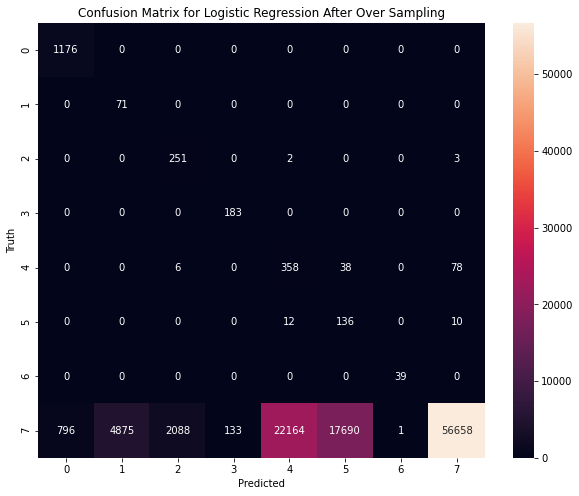

In [91]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Logistic Regression After Over Sampling')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [92]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.4117186635289666
Specificity is: 0.9390495327069952
Sensitivity is : 0.891217092029986
F1 Score is : 0.42982639627019104
roc_auc_score is: 0.9993191675699353
True Positive : [ 1176    71   251   183   358   136    39 56658]
True Positive sum Is : 58872
False Positive : [  796  4875  2094   133 22178 17728     1    91]
False Positive sum Is : 47896
True Negative : [104796 101822 104418 106452  84110  88882 106728   2272]
True Negative sum Is : 699480
False Negative : [    0     0     5     0   122    22     0 47747]
False Negative sum Is : 47896


In [1]:
## Decision Tree Classifier After Oversampling

In [93]:
from sklearn.tree import DecisionTreeClassifier
dtcos = DecisionTreeClassifier(max_depth = 5, random_state = 1)
dtcos.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [94]:
pred = dtcos.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print('\n')
print(classification_report(y_test,pred))

0.9359358609321144


[[ 1176     0     0     0     0     0     0     0]
 [    0    54     0    17     0     0     0     0]
 [    0     0   253     3     0     0     0     0]
 [    0     0     0   183     0     0     0     0]
 [    0     0     0     8   380     0     0    92]
 [    0     0     0     0     0   146     0    12]
 [    0     0     0     0     0     0    39     0]
 [ 1505     0   225   122     1  4850     5 97697]]


              precision    recall  f1-score   support

           0       0.44      1.00      0.61      1176
           1       1.00      0.76      0.86        71
           2       0.53      0.99      0.69       256
           3       0.55      1.00      0.71       183
           4       1.00      0.79      0.88       480
           5       0.03      0.92      0.06       158
           6       0.89      1.00      0.94        39
           7       1.00      0.94      0.97    104405

    accuracy                           0.94    106768
   macro avg       0.68   

Text(69.0, 0.5, 'Truth')

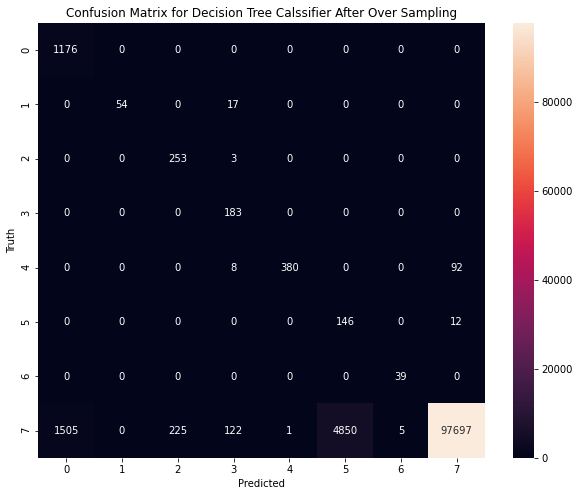

In [95]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Decision Tree Calssifier After Over Sampling')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [96]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.6786724386836447
Specificity is: 0.9865832796611966
Sensitivity is : 0.9250390166742578
F1 Score is : 0.714737021424532
roc_auc_score is: 0.9993191675699353
True Positive : [ 1176    54   253   183   380   146    39 97697]
True Positive sum Is : 99928
False Positive : [1505    0  225  150    1 4850    5  104]
False Positive sum Is : 6840
True Negative : [104087 106697 106287 106435 106287 101760 106724   2259]
True Negative sum Is : 740536
False Negative : [   0   17    3    0  100   12    0 6708]
False Negative sum Is : 6840


In [96]:
### Linear Discriminant After Oversampling:

In [97]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ldaos = LinearDiscriminantAnalysis()
ldaos.fit(X_train,y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [98]:
pred = ldaos.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print('\n')
print(classification_report(y_test,pred))

0.24660010490034467




              precision    recall  f1-score   support

           0       0.11      1.00      0.19      1176
           1       0.00      0.76      0.01        71
           2       0.03      0.96      0.06       256
           3       0.17      1.00      0.30       183
           4       0.02      0.75      0.03       480
           5       0.01      0.79      0.01       158
           6       0.01      1.00      0.03        39
           7       1.00      0.23      0.38    104405

    accuracy                           0.25    106768
   macro avg       0.17      0.81      0.12    106768
weighted avg       0.98      0.25      0.37    106768



Text(69.0, 0.5, 'Truth')

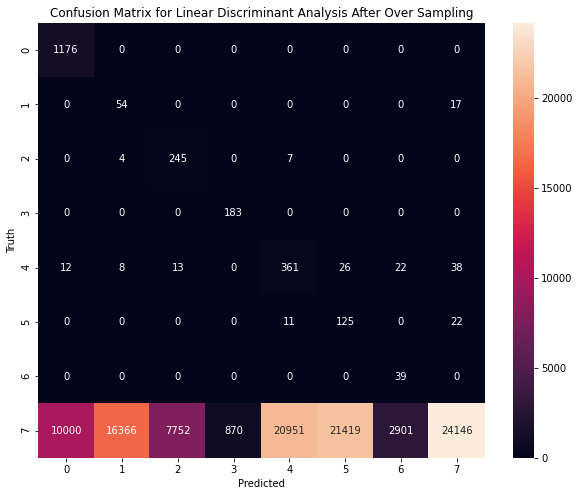

In [99]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Linear Discriminant Analysis After Over Sampling')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [100]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.1681853023878624
Specificity is: 0.9015257173335306
Sensitivity is : 0.8115112065948588
F1 Score is : 0.12477625023489322
roc_auc_score is: 0.9993191675699353
True Positive : [ 1176    54   245   183   361   125    39 24146]
True Positive sum Is : 26329
False Positive : [10012 16378  7765   870 20969 21445  2923    77]
False Positive sum Is : 80439
True Negative : [ 95580  90319  98747 105715  85319  85165 103806   2286]
True Negative sum Is : 666937
False Negative : [    0    17    11     0   119    33     0 80259]
False Negative sum Is : 80439


In [2]:
### MLP Classifier After OverSampling:

In [101]:
from sklearn.neural_network import MLPClassifier
mlpos = MLPClassifier()
mlpos.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [102]:
pred = mlp.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print(classification_report(y_test,pred))

0.999597257605275


[[  1176      0      0      0      0      0      0      0]
 [     0     71      0      0      0      0      0      0]
 [     0      0    256      0      0      0      0      0]
 [     0      0      0    183      0      0      0      0]
 [     0      0      0      0    480      0      0      0]
 [     0      0      0      0      0    158      0      0]
 [     0      0      0      0      0      0     39      0]
 [    42      0      0      0      1      0      0 104362]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1176
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00       256
           3       1.00      1.00      1.00       183
           4       1.00      1.00      1.00       480
           5       1.00      1.00      1.00       158
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00    104405

    accuracy       

Text(69.0, 0.5, 'Truth')

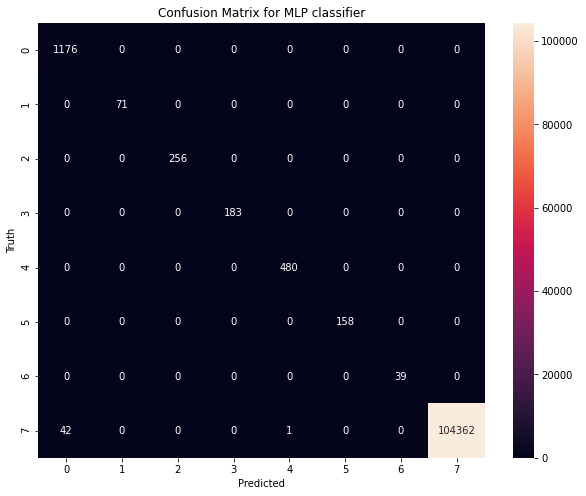

In [103]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for MLP classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [104]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.9954297799125386
Specificity is: 0.9999491042742896
Sensitivity is : 0.9999485177912935
F1 Score is : 0.9976511982967882
roc_auc_score is: 0.9993191675699353
True Positive : [  1176     71    256    183    480    158     39 104362]
True Positive sum Is : 106725
False Positive : [42  0  0  0  1  0  0  0]
False Positive sum Is : 43
True Negative : [105550 106697 106512 106585 106287 106610 106729   2363]
True Negative sum Is : 747333
False Negative : [ 0  0  0  0  0  0  0 43]
False Negative sum Is : 43


In [3]:
### AdaBoost Calssifier After OverSampling:

In [105]:
from sklearn.ensemble import AdaBoostClassifier
adbos = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5,random_state = 1),n_estimators = 50)
adbos.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [106]:
pred = adb.predict(X_test)
print(accuracy_score(y_test,pred))
print('\n')
cm = confusion_matrix(y_test,pred)
print(cm)
print(classification_report(y_test,pred))

0.9999812677955942


[[  1176      0      0      0      0      0      0      0]
 [     0     71      0      0      0      0      0      0]
 [     0      0    256      0      0      0      0      0]
 [     0      0      0    183      0      0      0      0]
 [     0      0      0      0    480      0      0      0]
 [     0      0      0      0      0    158      0      0]
 [     0      0      0      0      0      0     39      0]
 [     1      0      0      0      1      0      0 104403]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1176
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00       256
           3       1.00      1.00      1.00       183
           4       1.00      1.00      1.00       480
           5       1.00      1.00      1.00       158
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00    104405

    accuracy      

Text(69.0, 0.5, 'Truth')

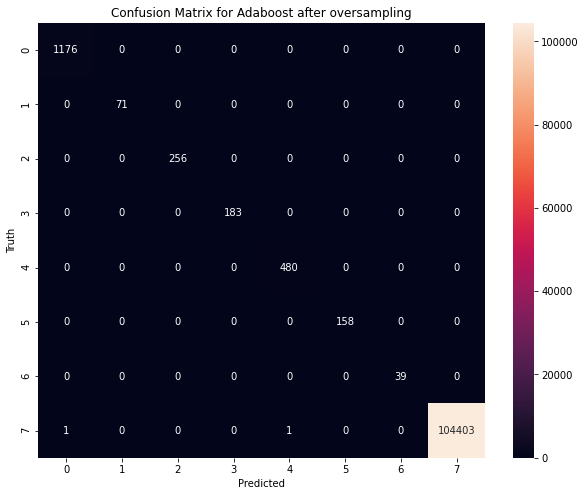

In [107]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion Matrix for Adaboost after oversampling')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [108]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

specificity = TNR.sum() / 8
sensitivity = TPR.sum() /8
precision = PPV.sum() /8
f1score = f1_score(y_test,pred,average='macro')
rocaucscore = roc_auc_score(y_test,rfc.predict_proba(X_test),multi_class='ovr')
print("Precision : {0}".format(precision))
print("Specificity is: {0}".format(specificity))
print("Sensitivity is : {0}".format(sensitivity))
print("F1 Score is : {0}".format(f1score))
print("roc_auc_score is: {0}".format(rocaucscore))

print("True Positive : {0}".format(TP))
print("True Positive sum Is : {0}".format (TP.sum()))

print("False Positive : {0}".format(FP))
print("False Positive sum Is : {0}".format (FP.sum()))

print("True Negative : {0}".format(TN))
print("True Negative sum Is : {0}".format (TN.sum()))

print("False Negative : {0}".format(FN))
print("False Negative sum Is : {0}".format (FN.sum()))



Precision : 0.9996339225311188
Specificity is: 0.9999976401482195
Sensitivity is : 0.9999976054786648
F1 Score is : 0.9998156062151657
roc_auc_score is: 0.9993191675699353
True Positive : [  1176     71    256    183    480    158     39 104403]
True Positive sum Is : 106766
False Positive : [1 0 0 0 1 0 0 0]
False Positive sum Is : 2
True Negative : [105591 106697 106512 106585 106287 106610 106729   2363]
True Negative sum Is : 747374
False Negative : [0 0 0 0 0 0 0 2]
False Negative sum Is : 2
